In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import anndata

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)
library(stringr)
library(EnhancedVolcano)

In [13]:
path_out = "/home/sch/schonner/MaPra/test"

In [4]:
adata_pb = sc.read("/home/sch/schonner/MaPra/merged_data_for_diffEx_edgeR.h5ad")
adata_pb

AnnData object with n_obs × n_vars = 508 × 23767
    obs: 'dataset', 'batch', 'sample', 'condition', 'fibrotic/control', 'coarse_harmonized_anno', 'harmonized_anno', 'author_annotation_coarse', 'author_annotation', 'lib_size', 'log_lib_size'
    uns: 'author_annotation_coarse_colors', 'author_annotation_colors', 'batch_colors', 'coarse_harmonized_anno_colors', 'condition_colors', 'dataset_colors', 'fibrotic', 'harmonized_anno_colors', 'log1p', 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [5]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$condition)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)   # keeps genes that have at least min.count (default: 10) reads in a worthwhile number samples
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create factors for the design matrix
    condition <- colData(adata_)$condition   # saline, asbestos, ...
    project <- colData(adata_)$dataset       # schiller, misharin, peyser, ...
    design <- model.matrix(~ 0 + condition + project)
    print(colnames(design))
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [6]:
adata_sub = adata_pb[adata_pb.obs["coarse_harmonized_anno"] == "Aerocytes"]
adata_sub.obs_names = [
    name.split("_")[2] + "_" + name.split("_")[3] for name in adata_sub.obs_names
]

In [7]:
%%time
%%R -i adata_sub
outs <- fit_model(adata_sub)

[1] "Dimensions before subsetting:"
[1] 23767    16
[1] ""
[1] "Dimensions after subsetting:"
[1] 8009   16
[1] ""
[1] "conditionasbestos"  "conditionbleomycin" "conditionuntreated"
[4] "projecttsukui"      "projectxie"        
CPU times: user 8.83 s, sys: 628 ms, total: 9.46 s
Wall time: 8.67 s


In [8]:
%%R
fit <- outs$fit
y <- outs$y

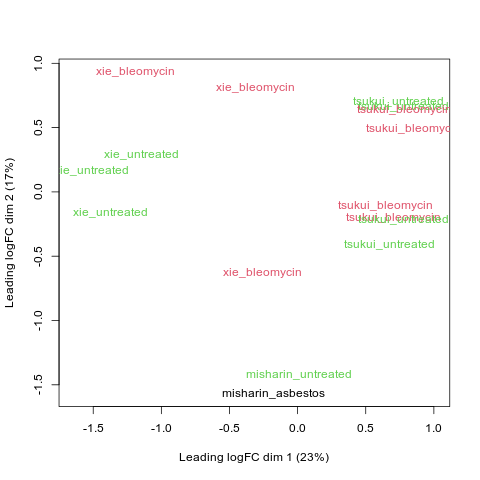

In [18]:
%%R 
plotMDS(y, labels = NULL, col = as.numeric(y$samples$group),
       title="MDS plot of the public merged data for Aerocytes")
ggsave(
    '~/merged_public_MDS_Aerocytes_shifted.png', plot = last_plot(),
    device = NULL, scale = 1, width = 30, height = 30, units = "cm", dpi = 300, limitsize = TRUE, bg = NULL
  )

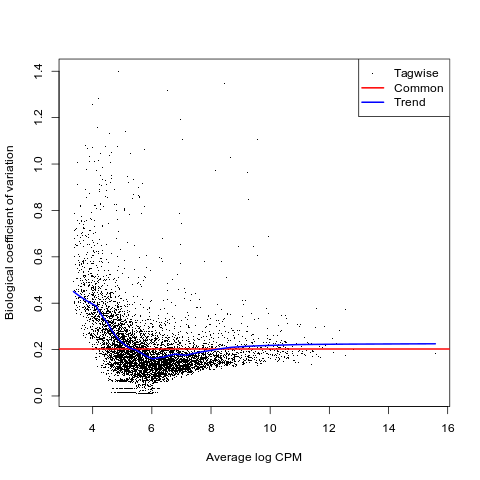

In [9]:
%%R
plotBCV(y, title="BVC plot of the public merged data for Aerocytes")
ggsave(
    path_out + 'merged_public_BVC_Aerocytes_shifted.png', plot = last_plot(), device = NULL,
    path = path_out, scale = 1, width = 30, height = 30, units = "cm",
    dpi = 300, limitsize = TRUE, bg = NULL, width = 30, height = 30
  )

In [10]:
%%R
# create contrast matrix
contrasts <- list()
for (colname in colnames(y$design)){
    if (startsWith(colname, "condition")){
          contrasts <- append(contrasts, colname)
    }
}
contrast_tmp <- paste(contrasts,collapse = '-')
myContrast <- makeContrasts(contrast_tmp, levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table
# 'normalize' logFc
mean_FC <- mean(tt$logFC)
tt$logFC_shifted <- (tt$logFC - mean_FC)


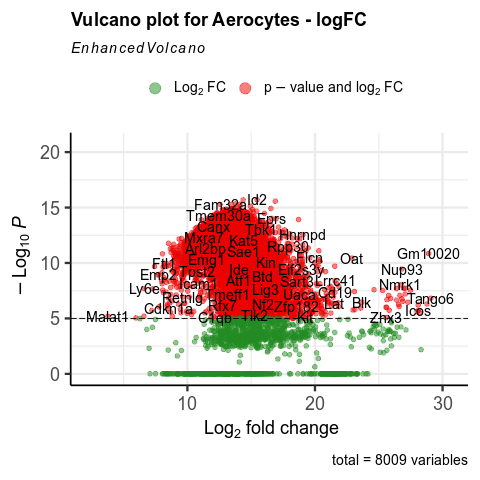

In [13]:
%%R
EnhancedVolcano(tt, lab = rownames(tt), x = 'logFC', y = 'PValue',
                  title = "Vulcano plot for Aerocytes - logFC")
ggsave(
    path_out + 'merged_public_Vulcano_Aerocytes.png', plot = last_plot(), device = NULL,
    path = path_out, scale = 1, width = 30, height = 30, units = "cm",
    dpi = 300, limitsize = TRUE, bg = NULL, width = 30, height = 30
  )

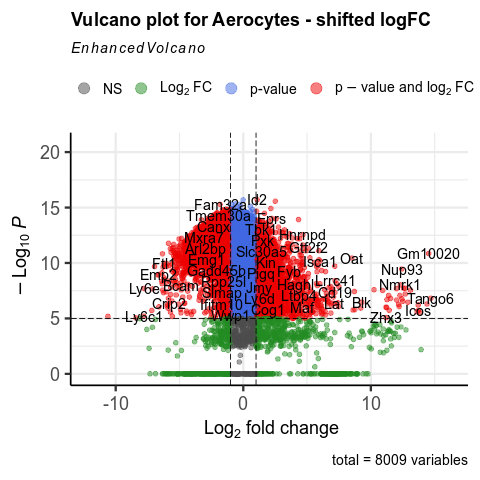

In [19]:
%%R
EnhancedVolcano(tt, lab = rownames(tt), x = 'logFC_shifted', y = 'PValue',
                 title = "Vulcano plot for Aerocytes - shifted logFC")
ggsave(
    path_out + 'merged_public_Vulcano_Aerocytes_shifted.png', plot = last_plot(), device = NULL,
    path = path_out, scale = 1, width = 30, height = 30, units = "cm",
    dpi = 300, limitsize = TRUE, bg = NULL, width = 30, height = 30
  )